## Librerias

In [1]:
#!pip3 install numpy
#!pip3 install opencv-python
#!pip3 install pandas
#!pip3 install scikit-learn
#!pip3 install ipywidgets

In [2]:
# Numpy para calculo vectorial
import numpy as np
import math
# cv2 para trabajar con imagenes
import cv2

# matplotlib para graficar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

# Pandas para manipular datos
import pandas as pd

# sklearn para machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.cluster import BisectingKMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing, decomposition
# 
from IPython.display import clear_output 
from collections import Counter
from ipywidgets import interact, widgets

In [3]:
plt.rcParams['figure.figsize'] = [5, 5]

## Funciones

In [4]:
def gen_df(image):
    """
    Generar df de una imagen BGR o Grayscale
    """
    
    shape = image.shape
    if len(shape) == 3:
      ny, nx, _ = shape
      ncols = 5
    elif len(shape) == 2:
      ny, nx = shape
      ncols = 3

    npix = ny*nx
    data = np.zeros([npix, ncols], dtype="int")
    ind = np.indices((ny, nx))

    data[:, 0] = ind[0].flatten() #filas
    data[:, 1] = ind[1].flatten() #columnas

    data[:, 2] = image[:, :, 0].flatten() #rojo
    data[:, 3] = image[:, :, 1].flatten() # verde
    data[:, 4] = image[:, :, 2].flatten() # azul

    df = pd.DataFrame(data, columns=["fila", "columna", "b", "g", "r"])
    
    return df

def crop_limits(img):
  """Recibe una imagen, espera a la seleccion de los puntos de interes
  y extrae la capsula de petri
  """
  def click_event(event, x, y, flags, params):
     if event == cv2.EVENT_LBUTTONDOWN:
        print(f'({x},{y})')

        # put coordinates as text on the image
        cv2.putText(img_copy, f'({x},{y})',(x,y),
        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # draw point on the image
        cv2.circle(img_copy, (x,y), 3, (0,255,255), -1)

        COORDS.append((x,y))
  
  COORDS = []

  # Copy the image to show and don't modify the original one
  img_copy = img.copy()

  # create a window
  cv2.namedWindow('Point Coordinates')

  # bind the callback function to window
  cv2.setMouseCallback('Point Coordinates', click_event)

  # display the image
  coords = []
  while True:
     cv2.imshow('Point Coordinates', img)
     k = cv2.waitKey(1) & 0xFF
     if len(COORDS) == 2:
      break

def mkcircle(image):
  """Borrar imagen fuera del circulo.

  Toma una imagen de un rectángulo y, asumiendo
  que los bordes de la imagen son tangentes al
  círculo, vuelve totalmente blancas las zonas
  externas al círculo.

  image: imagen cv2 (numpy array de tres dimensiones)
    Imagen a recortar
  """
  height = image.shape[0]
  width = image.shape[1]
  y_offset = 0
  x_offset = 0
  offset = -30
  for y in range(height):
    for x in range(width):
      if (
          (x - width/2 +x_offset) * (x - width/2 +x_offset) 
          + (y - height/2 +y_offset) * (y-height/2 +y_offset) 
          >= (height/2 + offset) * (height/2 +offset)
          ):
        
        image[y, x, 0] = 0
        image[y, x, 1] = 0
        image[y, x, 2] = 0
  return image

def mkcircle_petri(offset,background):
  """Borrar imagen fuera del circulo.

  Toma una imagen de un rectángulo y, asumiendo
  que los bordes de la imagen son tangentes al
  círculo, vuelve totalmente blancas las zonas
  externas al círculo.

  image: imagen cv2 (numpy array de tres dimensiones)
    Imagen a recortar
  """
  #image = petri
  height = petri.shape[0]
  width = petri.shape[1]
  for y in range(height):
    for x in range(width):
      if (
          (x - width/2) * (x - width/2) 
          + (y - height/2) * (y-height/2) 
          >= (height/2 - offset/10) * (height/2 -offset/10)
          ):
        
        petri[y, x, 0] = background
        petri[y, x, 1] = background
        petri[y, x, 2] = background
  plt.imshow(petri)
  
  #return petri
  return None

def blob_finder(image):
  """
  Esta funcion no se usa, la deje por las dudas. Se supone que puede
  identificar figuras genericas aisladas
  """
  # Set our filtering parameters
  # Initialize parameter setting using cv2.SimpleBlobDetector
  params = cv2.SimpleBlobDetector_Params()
  
  # Set Area filtering parameters
  params.filterByArea = False
  params.minArea = 10
  
  # Set Circularity filtering parameters
  params.filterByCircularity = True
  params.minCircularity = 0.9
  
  # Set Convexity filtering parameters
  params.filterByConvexity = False
  params.minConvexity = 0.2
  
  # Set inertia filtering parameters
  params.filterByInertia = True
  params.minInertiaRatio = 0.8
  
  # Create a detector with the parameters
  detector = cv2.SimpleBlobDetector_create(params)
  
  # Detect blobs
  keypoints = detector.detect(
    np.array(image, dtype="uint8")
  )
  
  # Draw blobs on our image as red circles
  blank = np.zeros((1, 1))
  blobs = cv2.drawKeypoints(
    image, keypoints, blank, (0, 0, 255),
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
  )

  return blobs

def get_area(image, msg):
  r = cv2.selectROI(msg, image)

  # Crop image
  img = image[
      int(r[1]):int(r[1]+r[3]),
      int(r[0]):int(r[0]+r[2])
  ]

  return img, r

def set_threshold(thresh_min, thresh_max):
  global thresh_min_out 
  global thresh_max_out 
  # Binarizar colonia deseada y entrenar kmeans
  desired_gray = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2GRAY)
  desired_bin = (
      (desired_gray > thresh_min) & (desired_gray < thresh_max)
  ) * 1
  thresh_min_out = thresh_min
  thresh_max_out  = thresh_max
  plt.imshow(desired_bin)
  plt.colorbar()
  plt.imshow(desired_colony, alpha=0.7)
  return thresh_min, thresh_max

# Carga de imágen a analizar y preprocesamiento
Se selecciona la imagen 

In [5]:
input_path = "27/input(27).jpg"
image = cv2.imread(input_path)
print(image.shape)

if image.shape >= (400,400,3):
    # Reducir el tamaño de imagen para agilizar el proceso
    image = cv2.resize(image,(400,400))
print(image.shape)

(1024, 1024, 3)
(400, 400, 3)


Se solicita al usuario seleccionar el area que ocupa la placa de Petri

In [6]:
# Selección de cápsula de petri
petri, petri_range = get_area(image, "Select Petri")
cv2.destroyWindow('Select Petri')

# Selección de colonia para etiquetar
desired_colony, colony_range = get_area(image, "Select Colony")
cv2.destroyWindow('Select Colony')

ny, nx, _ = petri.shape

Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!
Select a ROI and then press SPACE or ENTER button!
Cancel the selection process by pressing c button!


In [7]:
# Guardado de imagenes en otra parte, para tener acceso ante cualquier
# eventualidad
cv2.imwrite("tmp_petri.jpg", petri)
cv2.imwrite("tmp_desired_colony.jpg", desired_colony)

True

In [8]:
# Conversión de imagen BGR a RGB
petri = cv2.cvtColor(petri, cv2.COLOR_BGR2RGB)
desired_colony = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2RGB)
gray_petri = cv2.cvtColor(petri, cv2.COLOR_BGR2GRAY)

# Generación de DataFrames con las imágenes
df_petri = gen_df(petri)
df_desired = gen_df(desired_colony)

## Recortar exterior
Una vez teniendo la sección de la placa de Petri, se realiza un recorte de la 
zona exterior a la cápsula, asumiendo que la misma está representada como un
círculo perfecto (foto tomada de manera totalmente perpendicular y alineada
al centro de la placa)

In [9]:
interact(
    mkcircle_petri,
    offset=widgets.IntSlider(
        min=-petri.shape[0]*1.1,
        max=petri.shape[0]*1.1,
        step=1,
        value=-petri.shape[0]*10,
        layout=widgets.Layout(width='500px')
    ),
    background=widgets.IntSlider(
        min=0, 
        max=255,
        step=255, value=0,layout=widgets.Layout(width='200px')),
)

interactive(children=(IntSlider(value=-437, description='offset', layout=Layout(width='500px'), max=437, min=-…

<function __main__.mkcircle_petri(offset, background)>

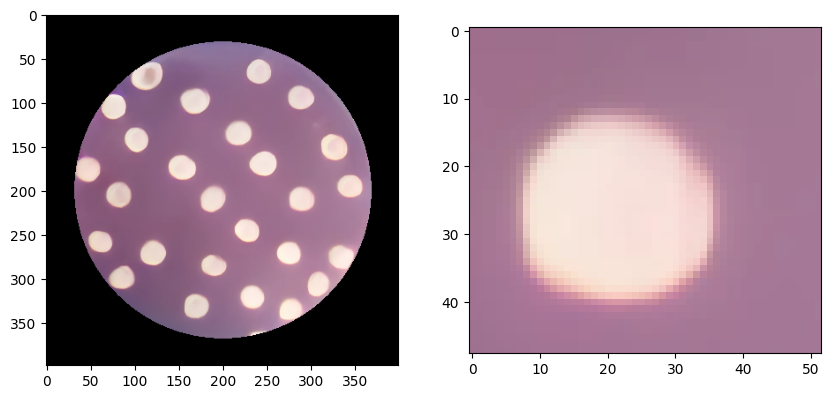

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

ax[0].imshow(petri)
ax[1].imshow(desired_colony)

# Clusterizacion con KNN

## Binarización de colonia de interés

Como primer etapa, se binariza el recorte de entrenamiento de la imagen original
con el objetivo de aislar la región que compone a la colonia de interés.

Para realizar esto se utiliza un threshold, variando límite inferior y superior
hasta llegar a una separación adecuada.

Durante esta etapa también se muestra la imagen original al mismo tiempo que la
de binarización de manera superpuesta, con el objetivo de facilitar la correcta
selección de los límites.

In [26]:

# Obtención 
interact(
    set_threshold,
    thresh_min=widgets.IntSlider(min=0, max=255, step=1, value=0),
    thresh_max=widgets.IntSlider(min=0, max=255, step=1, value=0)
)



interactive(children=(IntSlider(value=0, description='thresh_min', max=255), IntSlider(value=0, description='t…

<function __main__.set_threshold(thresh_min, thresh_max)>

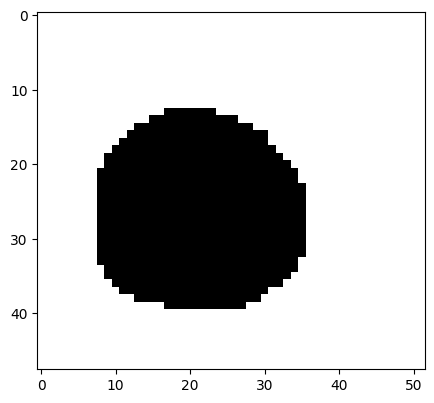

In [39]:
# Binarizar colonia deseada ocn los valores seteados
desired_gray = cv2.cvtColor(desired_colony, cv2.COLOR_BGR2GRAY)
desired_bin = ((thresh_min_out < desired_gray) & (desired_gray < thresh_max_out)) * 1
plt.imshow(desired_bin)

In [40]:
df_desired["label"] = desired_bin.flatten()
df_desired

,fila,columna,b,g,r,label
0,0,0,158,110,140,0
1,0,1,158,110,140,0
2,0,2,158,110,140,0
3,0,3,158,110,140,0
4,0,4,157,111,140,0
...,...,...,...,...,...,...
2491,47,47,164,119,150,0
2492,47,48,165,119,150,0
2493,47,49,165,119,150,0
2494,47,50,165,119,150,0


## Entrenamiento KNN
Una vez definido el DataFrame con los datos catalogados se procede a entrenar un
modelo clasificador para detectar la colonia deseada. Como modelo se eligió
K-Nearest Neighbours (KNN), debido a que las colonias se tratan de datos 
agrupados por regiones.

In [41]:
knn = KNeighborsClassifier(n_neighbors=20, weights="distance")
knn.fit(df_desired.iloc[:, 2:-1], df_desired["label"])

KNeighborsClassifier(n_neighbors=20, weights='distance')

## Predicción en todo el set de datos
Una vez teniendo el modelo entrenado se realiza la predicción en toda la imagen.

Cluster:  0


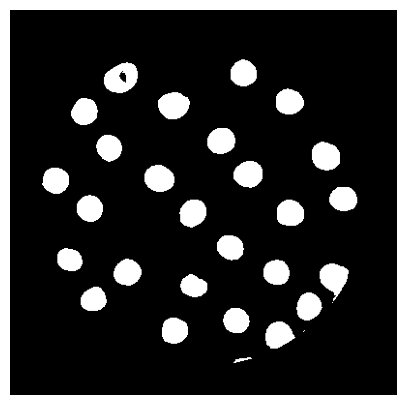

Cluster:  1


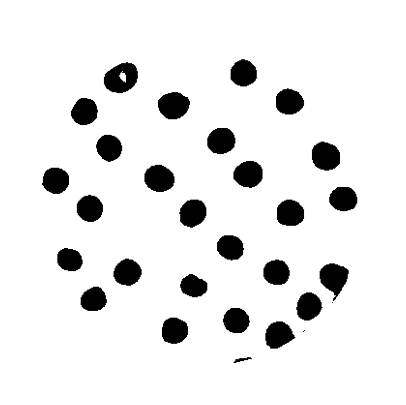

In [42]:
# Genero dataframe de la imagen original (recortada)
df_petri = gen_df(petri)

# Prediccion con KMeans entrenada
labels = knn.predict(df_petri.iloc[:, 2:])
df_petri["labels"] = labels

for label in df_petri["labels"].unique():
    print("Cluster: ", label)
    colonies = (df_petri["labels"].values.reshape((ny, nx)) == label) * 1
    plt.imshow(colonies)
    plt.axis('off')
    plt.set_cmap(cmap="binary")
    plt.axis('off')
    plt.show()

# Conteo de número de UFCs

Para el conteo de UFCs se implementaron dos métodos:

- Relaciones de áreas
- Conteo de puntos

### Relaciones de áreas

Sabiendo el número de colonias en el recorte realizado se calcula el área
promedio que corresponde a una colonia. El área se mide en unidades de pixeles
y el área promedio se determina según:

$\frac{N_{pixeles totales}}{N_{colonias}}$

In [45]:
# Cantidad de colonias en el recorte de clasificación
n_desired = 1

# Determinación de area promedio
area = len(df_desired[df_desired["label"] == label])
mean_area = area/n_desired

if mean_area <= 0:
    raise Exception("Ajustar la Binarización de la Colonia")

# Determinación de número de colonias
n_colonies = len(df_petri[df_petri["labels"] == label])/mean_area

print(f"Hay {math.ceil(n_colonies)} colonias")

Hay 26 colonias


In [55]:
# Codigo de conteo de areas cerradas
# https://stackoverflow.com/questions/47566093/computer-vision-counting-small-circles-in-an-image
ResultingList = [0]*2

#Analizar cada una de las imagenes creadas
for i in list(range(2)):
    img = cv2.imread("Colonies"+str(i)+".png", cv2.IMREAD_GRAYSCALE)
    countx = 0
    county = 0
  
    #Verificar que tiene un recuadro blanco y pintar a negro:
    for k in list(range(0,img.shape[1]-1)):
        if (img[int(img.shape[0]/2),k] == 255):
            countx+=1
        else: break
    for j in list(range(0,img.shape[0]-1)):
        if (img[j,int(img.shape[1]/2)] == 255):
            county+=1
        else: break

    if countx <=10:
        for m in list(range(0,img.shape[0]-1)):
            img[m,:10] = 0
            img[m,-10:] = 0
        for n in list(range(0,img.shape[1]-1)):
            img[:10,n] = 0
            img[-10:,n] = 0

    #Invertir colores (blanco a negro y negro a blanco):
    for r in list(range(0,img.shape[1]-1)):
        for s in list(range(0,img.shape[0]-1)):
            if (img[s,r] == 255):
                img[s,r] = 0
            else:
                img[s,r] = 255

   
    #Crear un rectangulo de 3x3 como kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    #Aplicar un umbral con los limites establecidos antes
    mask = cv2.threshold(img, thresh_min_out, thresh_max_out, cv2.THRESH_BINARY)[1]


    #Eliminar ruido de la imagen
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #Se terminan de rellenar las areas cerradas
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    #Se cuentan todas las areas cerradas que encuentra en la imagen
    n_centers = cv2.connectedComponents(mask)[0] - 1
    print(n_centers)
    ResultingList[i] = n_centers 

#Ordenar de menor a mayor el conteo
ResultingList = sorted(ResultingList)

#Comunicar la mediana de los resultados
print('Hay %d colonias.'%ResultingList[int((2-1))])

#https://stackoverflow.com/questions/47566093/computer-vision-counting-small-circles-in-an-image

1
24
Hay 24 colonias.
